# Evaluate E1 models

Based on pix2pix/test.py and eval_B1_C1_D1 notebook

In [55]:
import os
import random
import uuid
from datetime import datetime
from tempfile import gettempdir
from typing import Tuple, List

import cv2
import mediapipe as mp
import numpy as np
from tqdm import tqdm

import common_functions as core

# E1 vs E2 - evaluating using Average Keypoint Distance

As described in the FOMM model paper - AKD is obtained by computing the average distance between the detected keypoints of the ground truth and of the generated video


In [56]:
def temp_image_file(prefix="I") -> str:
    """
    Create a temporary image filename and return it
    """
    current_date_time_str = datetime.now().strftime("%Y%m%d%H%M%S")[2:]
    uuid_str = str(uuid.uuid4())[:8]
    filename = f"{prefix}_{current_date_time_str}_{uuid_str}.png".lower()
    return os.path.join(gettempdir(), filename)


POSE = mp.solutions.pose.Pose(static_image_mode=True, min_detection_confidence=0.05, min_tracking_confidence=0.02)
INFERENCE = core.Inference(temp_image_file)


I0000 00:00:1724594422.503198  197361 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1 Pro
W0000 00:00:1724594422.558582  205167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1724594422.567351  205166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: /Users/tashvit/Documents/GitHub/mmpixagen/checkpoints	[default: ./checkpoints]
                crop_size: 64                            	[default: 256]
                 dataroot: datasets/model_a3_data        	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 64                            	[default: 256]
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                    

In [57]:

def compute_euclidean_distance(point1, point2):
    """
    Calculate distance between two points
    :param point1: first point
    :param point2: second point
    """
    return np.linalg.norm(np.array(point1) - np.array(point2))


def detect_keypoints(image) -> Tuple[list, list]:
    """
    Use mediapipe Pose model to detect keypoints
    :param image: input image
    :returns: keypoints and visibility for each keypoint (33 keypoints)
    """
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = POSE.process(image_rgb)

    keypoints = []
    visibility = []
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            keypoints.append((landmark.x, landmark.y))
            visibility.append(landmark.visibility)

    return keypoints, visibility


def calculate_akd_score(image1, image2) -> float:
    """
    Calculate AKD score between two images
    :param image1: first image
    :param image2: second image
    """
    keypoints1, _ = detect_keypoints(image1)
    keypoints2, _ = detect_keypoints(image2)

    # If the number of keypoints are different, then we cannot compare
    if len(keypoints1) != len(keypoints2) or len(keypoints1) == 0 or len(keypoints2) == 0:
        raise ValueError("Number of keypoints do not match")

    distances = []
    for i, (point1, point2) in enumerate(zip(keypoints1, keypoints2)):
        distance = compute_euclidean_distance(point1, point2)
        distances.append(distance)

    return np.mean(distances)


def calculate_akd(image_pairs: List[Tuple[core.Image, core.Image]]) -> Tuple[int, float, float, float]:
    """
    Calculate AKD for all the image pairs, then return metrics
    :param image_pairs: list of (generated_image, ground_truth_images)
    :return: sample_count, mean, median, 75th percentile
    """
    akd_scores = []

    for gen, ground in image_pairs:
        generated_image = core.pil_to_opencv(gen)
        target_image = core.pil_to_opencv(ground)
        
        try:
            akd_score = calculate_akd_score(generated_image, target_image)
        except ValueError:
            continue
        akd_scores.append(akd_score)

    p75 = np.percentile(akd_scores, 75)
    # Calculate median of AKD scores
    median = np.median(akd_scores)
    # Calculate mean of AKD scores
    mean = np.mean(akd_scores)
    return len(akd_scores), mean, median, p75



datasets/model_e2_data/test/0028/08.png


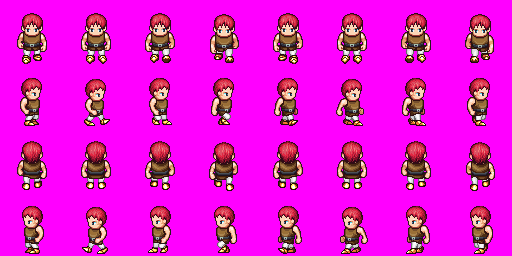

In [58]:
sheet, frontface = core.load_test_sheet("datasets/model_e2_data/test/0028")
print(frontface)
sheet

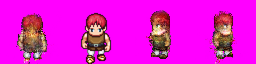

In [59]:
INFERENCE.directional_images_sheet(frontface)

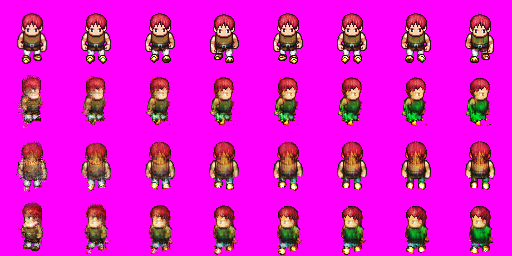

In [60]:
INFERENCE.create_sheet_e1(frontface)

In [61]:
e2 = INFERENCE.create_sheet_e2(frontface)

/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


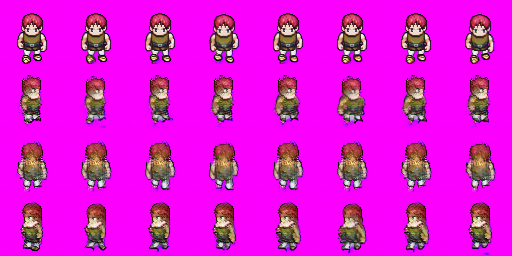

In [62]:
e2

In [63]:
def break_apart(image: core.Image) -> List[core.Image]:
    """
    Break apart given spritesheet to individual images
    :param image: input image
    :return: list of images after breaking apart (32 images)
    """
    images = []
    for r in range(4):
        for c in range(8):
            w = 64
            h = 64
            x1 = c * w
            y1 = r * h
            x2 = x1 + w
            y2 = y1 + h
            single_frame = image.crop((x1, y1, x2, y2))
            images.append(single_frame.resize((256, 256), resample=core.Image.Resampling.NEAREST))
    return images

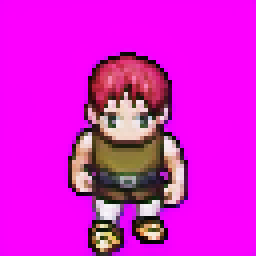

In [64]:
len(break_apart(e2))
break_apart(e2)[0]

In [65]:
def create_eval_pairs(limit=25):
    test_path = "datasets/model_e2_data/test"
    test_data = os.listdir(test_path)
    random.shuffle(test_data)
    test_data = test_data[:limit]  # get limited number of test sheets
    # --------------------------------
    e1_data = []
    e2_data = []
    for test_name in tqdm(test_data):
        path = os.path.join(test_path, test_name)
        ground, front_face = core.load_test_sheet(path)
        e1 = INFERENCE.create_sheet_e1(front_face)
        e2 = INFERENCE.create_sheet_e2(front_face)
        ground_images = break_apart(ground)
        e1_images = break_apart(e1)
        e2_images = break_apart(e2)

        e1_pairs = list(zip(e1_images, ground_images))
        e1_data.extend(e1_pairs)
        e2_pairs = list(zip(e2_images, ground_images))
        e2_data.extend(e2_pairs)
    
    return e1_data, e2_data

In [66]:
e1_data, e2_data = create_eval_pairs()

  0%|          | 0/25 [00:00<?, ?it/s]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:05<00:00,  1.59it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.61it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


  4%|▍         | 1/25 [00:33<13:19, 33.32s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.62it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


  8%|▊         | 2/25 [01:05<12:35, 32.83s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 12%|█▏        | 3/25 [01:38<11:58, 32.67s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:05<00:00,  1.59it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 16%|█▌        | 4/25 [02:11<11:29, 32.83s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:05<00:00,  1.55it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 20%|██        | 5/25 [02:44<10:59, 32.99s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:05<00:00,  1.43it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 24%|██▍       | 6/25 [03:21<10:54, 34.47s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:05<00:00,  1.59it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.61it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.61it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 28%|██▊       | 7/25 [03:55<10:12, 34.02s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 32%|███▏      | 8/25 [04:27<09:27, 33.38s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:05<00:00,  1.53it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.62it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 36%|███▌      | 9/25 [04:59<08:47, 32.94s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.60it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 40%|████      | 10/25 [05:31<08:09, 32.64s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 44%|████▍     | 11/25 [06:02<07:31, 32.27s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 48%|████▊     | 12/25 [06:33<06:53, 31.77s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 52%|█████▏    | 13/25 [07:03<06:17, 31.44s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 56%|█████▌    | 14/25 [07:34<05:42, 31.17s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 60%|██████    | 15/25 [08:05<05:11, 31.10s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 64%|██████▍   | 16/25 [08:35<04:38, 30.93s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 68%|██████▊   | 17/25 [09:06<04:07, 30.90s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 72%|███████▏  | 18/25 [09:37<03:35, 30.83s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 76%|███████▌  | 19/25 [10:08<03:05, 30.86s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 80%|████████  | 20/25 [10:38<02:33, 30.78s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 84%|████████▍ | 21/25 [11:09<02:02, 30.72s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 88%|████████▊ | 22/25 [11:40<01:32, 30.69s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 92%|█████████▏| 23/25 [12:10<01:01, 30.74s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


 96%|█████████▌| 24/25 [12:41<00:30, 30.80s/it]/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]
/Users/tashvit/Documents/GitHub/mmpixagen/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---------------- MPS GPU Detected --------------------
Spritesheet mode: ['0000']
Frame count = 8


100%|██████████| 25/25 [13:12<00:00, 31.70s/it]


In [67]:
len(e1_data), len(e2_data)

(800, 800)

In [68]:
e1_score, e2_score = calculate_akd(e1_data), calculate_akd(e2_data)

# Scores
sample_count, mean, median, 75th perc

In [69]:
e1_score

(86, 0.17540207068382943, 0.12491664799310974, 0.23379222884401288)

In [70]:
e2_score

(42, 0.24830762094062975, 0.16701937374671244, 0.4105130858972018)

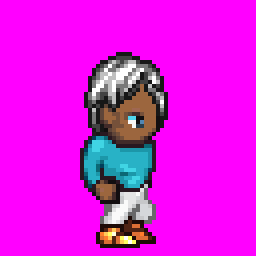

In [71]:
e1_data[40][1]

Lower distance is better, therefore `e1` has better AKD score than `e2`.